# Digital Piano Audio Tools
basic audio tools to quantify digital piano sound generation and reproduction. 
analyze 2ch phase issues that emerge from sound reproduction
- single note spectral levels, see: https://rtaylor.sites.tru.ca/2016/03/18/piano-phase/
- spectral levels for note harmonics, see: https://rtaylor.sites.tru.ca/2016/06/11/digital-pianos-part-2/

## Setup and Config
- using vscode default python server
- TODO: install sound libraries for audio playback from python 

**MIDIUtil**
see: https://pypi.org/project/MIDIUtil/

package installs
```
pip install MIDIUtil
```


## create MIDI test file
a standardized file to test multiple configurations or VSTs



In [9]:
# generate standard MIDI file for all piano notes
import pandas as pd


def load_midi_notes(piano=False):
    """
    MIDI note lookup table
    
    usage:
        midi_note_lookup = load_midi_notes()
    """
    df = pd.read_csv("./data/midi_notes.csv")
    df.set_index('MIDI', inplace=True, drop=False)
    if piano:
        df = df[ ~df.Piano.isnull() ].astype({'Piano':int})
    return df


def generateMIDI(filename=None, midi_range:tuple=None, volumes=(115,75,35), tempo=40
                    , basepath="./data/", write_file=True
)->(tuple, str):
    from midiutil import MIDIFile
    """generate a MIDI file which plays individual notes between midi_range (inclusive)
    the note duration is 1/2 a beat, returns a tuple of MIDI note attrs for each note

    args:
        filename: str, will only return list of dict, [ {notes}, ] if None
        midi_range: tuple(int,int) becomes a range of MIDI note numbers (inclusive)
                    list() of ints, e.g. [int, ...] 
                    ["piano","pianoteq"]
        volumes:tuple(int, ...),  [0...127] standard MIDI volumes
        tempo:int BPM, e.g. temp=60 is 1s per note

    returns:
        midi:tuple indexed tuple of dicts of midi attrs for each note e.g. ({'Piano': 1, 'Note': 'A0'}, ...)
    """
    # pianoteq trial silent notes: F#1, G#1, A#1, C#5, D#5, F#5, G#5 and A#5
    pianoteq_silent_midi_notes = [30, 32, 34, 73, 78, 80, 82]

    if midi_range in [None, "piano"]: # piano, 88 keys
        notes = range(21,21+88)  # MIDI note number, piano=[21...108] inclusive
    elif midi_range=="pianoteq":
        # skip pianoteq silent notes
        notes = [i for i in range(21,21+88) if i not in pianoteq_silent_midi_notes]
    elif isinstance(midi_range, tuple) and len(midi_range)==2:
        a, b = midi_range
        notes = range(a, b+1)
    elif isinstance(midi_range, (list, np.array)):
        notes = midi_range
    else:
        assert False, f'VALUE ERROR: midi_range expecting None or (int,int), got {midi_range}'

    if isinstance(volumes, int):
        volumes = [volumes]   # 0-127, as per the MIDI standard
    tempo    = tempo   # In BPM

    ticks_per_quarter = 240
    duration = int(ticks_per_quarter * 0.5)    # In beats, or 1/8 note at tempo
    track    = 0
    channel  = 0
    time     = 0    # In beats

    MyMIDI = MIDIFile(1, ticks_per_quarternote=ticks_per_quarter, eventtime_is_ticks=True)  # One track, defaults to format 1 (tempo track is created automatically)
    MyMIDI.addTempo(track, time, tempo)
    
    # get MIDI lookup table
    df_midi = load_midi_notes(piano=True)
    assert isinstance(df_midi, pd.DataFrame), f'ERROR: expecting a df of midi notes. CSV file not found? got, {df_midi.iloc[:5,:5]}'

    midi = []
    path = None
    for i, pitch in enumerate(notes):
        for j, volume in enumerate(volumes):
            MyMIDI.addNote(track, channel, pitch, time + ((i*len(volumes)+j) * ticks_per_quarter), duration, volume)
            # prop = (df_midi.loc[pitch, 'Piano':'Note']).to_dict()
            prop = (df_midi.loc[pitch, :]).to_dict()
            prop["Tempo"] = tempo
            prop["Volume"] = volume
            midi.append( prop )
    if filename is not None:
        path = f'{basepath}{filename}'
        if ~filename.lower().endswith('.mid'):
            path += ".mid"
        if write_file:
            with open(path, "wb") as output_file:
                MyMIDI.writeFile(output_file)
                print("OK, path=", path)

    return tuple(midi), path

# midi_props, midi_path = generateMIDI(filename="piano-88.ff.mid", midi_range="piano", volumes=(115))
midi_props, midi_path = generateMIDI(filename="pianoteq-88.ff.mid", write_file=False, midi_range="pianoteq", volumes=115)
# midi_props, midi_path = generateMIDI(filename="pianoteq-88.ff-mf-p.mid", midi_range="pianoteq", volumes=(115,75,35))

midi_path, midi_props[0:3]

('./data/pianoteq-88.ff.mid.mid',
 ({'MIDI': 21,
   'Piano': 1,
   'Note': 'A0',
   'Frequency': 27.5,
   'Tempo': 40,
   'Volume': 115},
  {'MIDI': 22,
   'Piano': 2,
   'Note': 'Bb0',
   'Frequency': 29.14,
   'Tempo': 40,
   'Volume': 115},
  {'MIDI': 23,
   'Piano': 3,
   'Note': 'B0',
   'Frequency': 30.87,
   'Tempo': 40,
   'Volume': 115}))

In [10]:
# imports
import os
import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy import signal
from scipy import stats
from scipy.io import wavfile # get the api


np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

## [ISSUE] playing audio from np.arrays

### `sounddevice` FAIL
        https://python-sounddevice.readthedocs.io/en/0.4.2/installation.html
        on Mac OS X, you need to give your application the entitlement `com.apple.security.cs.allow-unsigned-executable-memory`
        see: https://cffi.readthedocs.io/en/latest/using.html#callbacks
        see also: https://github.com/spatialaudio/python-sounddevice/issues/270#issuecomment-939432642



### `IPython.display.Audio` FAIL
        not supported in vscode, see: https://github.com/microsoft/vscode/issues/118275
        ```
        import IPython.display as ipd
        ipd.Audio(clips[1][:32767], rate=samplerate, autoplay=True)
        ```

## Get data from WAV file

In [118]:
# with new meta format
def get_data_from_wav(filename:str, basepath:str="./data/")->dict:
    """ 
    """
    # path = "./data/pianoteq-88.ff.48K.binaural.wav"
    path = f'{basepath}{filename}'
    if ~filename.lower().endswith('.wav'):
        path += ".wav"

    samplerate, data = wavfile.read(path) # load the data
    data = data.T # data.shape = (channels, data)
    channels, samples = data.shape
    duration = samples/samplerate
    bitdepth_lu = {'int8':8., 'int16':16., 'int32':24., 'int64':64.}
    bitdepth = bitdepth_lu[ type(data[0,0]).__name__ ]
    basename = os.path.basename(path)
    basename = os.path.splitext(basename)[0]
    loc = locals()
    meta = {i: loc[i] for i in ("path","basename", "samplerate", "channels", "bitdepth", "duration")}
    # print(f'get_data_from_wav(): channels={channels}, samples={samples}, samplerate={samplerate}, duration={duration}s, bitdepth={bitdepth}')
    # print(f'get_data_from_wav(): {meta}')
    meta['data'] = data
    return meta


def clip_notes_from_data(dataOrDict:np.array, midi_props:tuple, samplerate=44100, offset=(50,100), tempo=None):
    """
    clip samples from audio file and add to midi dict

    
    NOTE: TRANSIENT_MS = 50


    usage:
        midi_props, midi_path = generateMIDI(filename="pianoteq-88.ff.mid", write_file=False, midi_range="pianoteq", volumes=115)
        # from DAW/VST, export MIDI file as xxx.wav
        wav_props = get_data_from_wav("xxx")
        notes = clip_notes_from_data(wav_props, midi_props, 
            samplerate=samplerate, tempo=40)


    args:
        dataOrDict: from get_data_from_wav()
            dict:{data, path, samplerate, channels, bitdepth, duration}
        midi_props: from generateMIDI()
            tuple:({'Piano': 1, 'Note': 'A0'}, ...)
        samplerate:int, default sample rate, but override with dataOrDict['samplerate']
        tempo:int, default MIDI BPM, but override with midi_props['Tempo']

    return
        {'MIDI': 108,
        'Piano': 88,
        'Note': 'C8',
        'Frequency': 4186.01,
        'Tempo': 40,
        'Volume': 115,
        'samplerate': 48000,
        'data': array()
        }
    """
    if isinstance(dataOrDict, dict):
        data = dataOrDict['data']
        samplerate = dataOrDict.get('samplerate', samplerate)
        ch = dataOrDict.get('channels', None)
    else:
        data = dataOrDict
        
    ch, sample_count = data.shape
    assert sample_count > ch and ch < 6, "ERROR: expecting audio.shape=(channels,sample_count)"

    # NOTE: piano attack transient seems to be about 50ms 
    if isinstance(offset, tuple):
        offsetL,offsetR = offset
    elif isinstance(offset, (int,float)):
        offsetL = offsetR = offset
    offsetL = int(samplerate*offsetL/1000)   
    offsetR = int(samplerate*offsetR/1000)

    i = 0
    clips = [i]
    for j, midi_prop in enumerate(midi_props):
        _tempo = midi_prop.get('Tempo', tempo)
        clip_sample_length = ms2samples(60/_tempo*1000, samplerate=samplerate)
        i += clip_sample_length
        assert i < sample_count, f'ValueError, {i}, {j}, {sample_count}'
        clips.append( i )
        # print(j, len(clips),  clip_sample_length, i+clip_sample_length, sample_count)

    clips = np.asarray( clips )
    

    # apply L/R offsets to clip boundaries
    end = clips[1:] - offsetR
    clips = clips[:-1]
    start = clips + offsetL
    clip_boundaries = np.vstack([clips, start, end]).T
    # print("expected clips=", len(midi_props), clip_boundaries.shape)

    # clip audio np.array on boundaries
    BEGIN, CLIP_START, CLIP_END = (0,1,2)   # index keys
    clip_indexes = [(i, clip_boundaries[i][CLIP_START], clip_boundaries[i][CLIP_END])  for i in range(clip_boundaries.shape[0])]
    assert len(midi_props)==len(clip_indexes), f'ERROR: expecting a dict of MIDI properties for each clip, got {len(midi_props)}!={len(clip_indexes)}'

    for i,a,b in clip_indexes:
        midi_props[i]['samplerate'] = samplerate
        midi_props[i]['data'] = data[:, a:b]

    return midi_props


midi_props, midi_path = generateMIDI(filename="pianoteq-88.ff.mid", write_file=False, midi_range="pianoteq", volumes=115)
wav_props = get_data_from_wav("pianoteq-88.ff.48K.binaural")
wav_props = get_data_from_wav("pianoteq-88.ff.48K.mic")
samplerate = wav_props['samplerate']
midi_props = clip_notes_from_data(wav_props, midi_props
    , offset=(100,100)
    , samplerate=samplerate, tempo=40)
midi_props[12]

{'MIDI': 36,
 'Piano': 16,
 'Note': 'C2',
 'Frequency': 65.41,
 'Tempo': 40,
 'Volume': 115,
 'samplerate': 48000,
 'data': array([[ 2841,  2573,  2192, ...,    -7,    -8,    -8],
        [-2087, -2428, -2785, ...,   -44,   -43,   -45]], dtype=int16)}

## spectral levels for notes (harmonic analysis)
> To create these graphs I struck and held each note on my CP50 (with the keyboard set to a fixed medium-loud strike velocity) and recorded 1 second of audio from both L and R line-level outputs.  Reverb and all other on-board effects were disabled, and EQ pots were at their center positions.  For each recording I calculated a mean spectrum (an average of several length-8192 windowed FFTs) after discarding the attack transient (about 20ms).  From each mean spectrum I extracted the amplitudes of the first 5 spectral peaks.  I did the same for the mono signal, derived by summing L+R channels (which is exactly what the unit’s “L/mono” line-level output does if there is no phone plug in the R jack).

`mean spectra`: Mean frequency spectrum of a time wave
* [R]: seewave.meanspec( ,wl=8192, from=0.02) - see: https://www.rdocumentation.org/packages/seewave/versions/2.1.6/topics/meanspec
* [python]: scipy.signal.welch() - see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html
    np.fft.fftfreq, np.fft.rfft

In [13]:
# general helpers
def humanize_number(num, precision=1, dropTrailingZero=True):
    """ 
    format numbers as strings for easy and compact reading

    from https://stackoverflow.com/questions/579310/formatting-long-numbers-as-strings-in-python/45846841
    https://stackoverflow.com/questions/11227620/drop-trailing-zeros-from-decimal
    """
    from math import log, floor
    from decimal import Decimal
    def _normalize_fraction(d):
        ### strip trailing 0
        normalized = d.normalize()
        sign, digit, exponent = normalized.as_tuple()
        return normalized if exponent <= 0 else normalized.quantize(1)

    units = ['', 'K', 'M', 'G', 'T', 'P']
    k = 1000.0
    magnitude = int(floor(log(num, k)))
    # s = '%.1f%s' % (num / k**magnitude, units[magnitude])
    result = Decimal(f'{num / k**magnitude:.{precision}f}')
    if dropTrailingZero:
        result = _normalize_fraction(result)
    return f'{result}{units[magnitude]}'

In [19]:
# audio/fft helpers
import math


def ms2samples(ms:int, samplerate=44100)->int:
    return int(ms/1000*samplerate)

def samples2ms(samples:np.array, samplerate=44100)->int:
    assert len(samples.shape)==2, f'ERROR: expecting 1- or 2-D array representing a multi-channel signal, got shape={samples.shape}'
    count = max(samples.shape)
    return int(count/samplerate*1000)

def sliceByMs(data:np.array, durationMS:int, offsetMS=0, samplerate=44100):
    assert len(data.shape)==2, f'ERROR: expecting 2D tensor, got shape={data.shape}'
    assert min(data.shape)<6, f'WARNING: expecting max 5-channel signal'
    start = ms2samples(offsetMS, samplerate=samplerate)
    keep = ms2samples(durationMS, samplerate=samplerate)
    ch, samples = data.shape
    is_channels_first = ch < samples
    return data[:, start:keep+start+1] if is_channels_first else data[start:keep+start+1, :]
    
def frequency_to_note(frequency, toStr=True):
    """see: https://stackoverflow.com/questions/64505024/turning-a-frequency-into-a-note-in-python
    """
    
    # define constants that control the algorithm
    NOTES = ['C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'Ab', 'A', 'Bb', 'B'] # these are the 12 notes in each octave
    OCTAVE_MULTIPLIER = 2 # going up an octave multiplies by 2
    KNOWN_NOTE_NAME, KNOWN_NOTE_OCTAVE, KNOWN_NOTE_FREQUENCY = ('A', 4, 440) # A4 = 440 Hz

    # calculate the distance to the known note
    # since notes are spread evenly, going up a note will multiply by a constant
    # so we can use log to know how many times a frequency was multiplied to get from the known note to our note
    # this will give a positive integer value for notes higher than the known note, and a negative value for notes lower than it (and zero for the same note)
    note_multiplier = OCTAVE_MULTIPLIER**(1/len(NOTES))
    frequency_relative_to_known_note = frequency / KNOWN_NOTE_FREQUENCY
    distance_from_known_note = math.log(frequency_relative_to_known_note, note_multiplier)

    # round to make up for floating point inaccuracies
    distance_from_known_note = round(distance_from_known_note)

    # using the distance in notes and the octave and name of the known note,
    # we can calculate the octave and name of our note
    # NOTE: the "absolute index" doesn't have any actual meaning, since it doesn't care what its zero point is. it is just useful for calculation
    known_note_index_in_octave = NOTES.index(KNOWN_NOTE_NAME)
    known_note_absolute_index = KNOWN_NOTE_OCTAVE * len(NOTES) + known_note_index_in_octave
    note_absolute_index = known_note_absolute_index + distance_from_known_note
    note_octave, note_index_in_octave = note_absolute_index // len(NOTES), note_absolute_index % len(NOTES)
    note_name = NOTES[note_index_in_octave]
    return f'{note_name}{note_octave}' if toStr else (note_name, note_octave)


def get_xticks_for_fft(fundamental:int, octave=True)->(list, list):
    """
    for a given MIDI frequency, return octave based tick range and note/freq labels for use with pyplot 
    """
    arange = [fundamental]
    while True:
        v = arange[-1]*2
        if v < 20000:
            arange.append(v)  
        else: 
            break
    labels = [ f'{frequency_to_note(v)}, {humanize_number(v, precision=1)}' for v in arange]
    return arange, labels

def play_clip(clip, basepath="./wav/", name="clip", samplerate=44100):
    if False:
        # sounddevice requires missing entitlement
        import sounddevice as sd
        fs = samplerate
        sd.play(clip, samplerate)
    if "use temp file":
        # use temp file for now
        LIMIT = 32767
        data = clip[:,:LIMIT].T
        #TODO: not writing 2 channel clips correctly
        path = f'{basepath}{name}.wav'
        wavfile.write(path, int(samplerate), data)
        # cannot autoplay because ipd.Audio() not supported in vscode/jupyter
        # ipd.display(ipd.Audio(path, autoplay=True) )
        print(f'wrote sound clip, path={path}')




In [15]:

# specialized helpers
def _find_audio_peaks(audio, samplerate=44100, durationMS=1200, expected=240):
    """find clip points for notes in audio file using signal.find_peaks()

    not working for all cases. if clock/tempo is known, use ms2samples() instead
    """
    data = audio[0]
    print(f'warning: find_peaks works on channel 1 only')
    # add peak min duration or prominence?
    # threshold = np.max(audio)*0.5
    distance = samplerate*durationMS/1000
    peaks, _ = signal.find_peaks(data, distance=distance)
    # NOTE: piano attack transient seems to be about 50ms BEFORE peak
    # TODO: sanity check, need better method for finding note boundaries
    check = len(peaks)/expected*100
    assert 80.<=check and check <=125., f'WARNING: found {len(peaks)} peaks, expected {expected}, {check}'
    return peaks



def clip_notes_from_audio(audio, samplerate=44100, offset=(0,100))->(tuple, np.array):
    """
    see also: clip_notes_from_data(dataOrDict, )

    args:
        tempo:int - Beats/Min
        expected:tuple of expected MIDI note props from audio file
        meta: list of dict for each clip
    """
    ch, samples = audio.shape
    assert samples > ch and ch < 6, "ERROR: expecting audio.shape=(channels,samples)"
    # NOTE: piano attack transient seems to be about 50ms 
    if isinstance(offset, tuple):
        offsetL,offsetR = offset
    elif isinstance(offset, (int,float)):
        offsetL = offsetR = offset
    offsetL = int(samplerate*offsetL/1000)   
    offsetR = int(samplerate*offsetR/1000)
    # TODO: warning, one channel only
    peaks = _find_audio_peaks(audio, samplerate=samplerate)

    sample_count = audio.shape[1]
    # apply L/R offsets to clip boundaries
    start = peaks + offsetL
    end = peaks[1:] - offsetR
    end =  np.append(end, [sample_count] , axis=0 ) # use last sample as last clip
    clip_boundaries = np.vstack([peaks, start, end]).T

    # clip audio np.array on boundaries
    BEGIN, CLIP_START, CLIP_END = (0,1,2)   # index keys
    clip_indexes = [(i, clip_boundaries[i][CLIP_START], clip_boundaries[i][CLIP_END])  for i in range(clip_boundaries.shape[0])]


    clips = ( audio[:, a:b]  for i,a,b in clip_indexes )
    print( f'samplerate={samplerate}, notes={peaks.shape}, offset={(offsetL, offsetR)}')
    print( f'clip length shapes: {[ x.shape for x in clips[:3]]}... {[ x.shape for x in clips[-3:]]} ')
    print( f'clip boundaries (sample)={boundaries[:3]} ... boundaries[:3]={boundaries[-3:]}')
    return clips, clip_boundaries



def get_spectra(clip, samplerate=44100, durationMS=600)->list:
    """ 
    get spectra for a 600ms sample
    
    args:
        clip:np.array - shape=(channels, samples)

    returns: 
        [ (xf,yf), ...], list of tuples, one for each channel
    """
    channels, samples = clip.shape
    assert channels<6, f'ERROR: expecting data.shape=(channels, samples), got shape={clip.shape}'

    result = []
    for ch in range(clip.shape[0]):
        # see https://realpython.com/python-scipy-fft/
        # Number of samples in normalized_tone
        samples = ms2samples(durationMS, samplerate=samplerate) # 600ms sample
        # samples = len(clip[ch]) # use ENTIRE clip
        yf = rfft(clip[ch][0:samples])
        xf = rfftfreq(samples, d=1./samplerate)
        result.append( (xf,yf) )
    # print(f'get_spectra(): samplerate={samplerate}')
    return result






In [111]:
def process_clips(midi_props
                    , samplerate=44100, offsetMS=70, durationMS=600, min_peak_ratio=0.10
):
    """
    NOTE: this method will mutate midi_props elements, e.g. midi_props[i]

    returns midi_props:tuple with updated values
    """
    for i, midi_prop in enumerate(midi_props):
        midi_props[i]['fft'] = get_fft(midi_prop, samplerate=samplerate, offsetMS=offsetMS, durationMS=durationMS, min_peak_ratio=min_peak_ratio)
        midi_props[i]['corrcoeff'] = get_corrcoef(midi_prop, offsetMS=offsetMS, durationMS=durationMS)

    return midi_props

def get_fft(midi_prop, samplerate=44100, offsetMS=70, durationMS=600, min_peak_ratio=0.10):
    """ 
    get fft results for midi_prop
    """
    samplerate = midi_prop.get('samplerate', samplerate)
    offsetL = int(samplerate*offsetMS/1000) # skip transient
    clip_spectra_by_channel = get_spectra(midi_prop['data'][:, offsetL:], samplerate=samplerate, durationMS=durationMS)

    # process each channel in clip
    channels = []
    first_fundamentals = []
    for ch, (xf,yf) in enumerate(clip_spectra_by_channel):
        yf_real = np.abs(yf)
        fft_peaks_min_height = max(yf_real)*min_peak_ratio
        fft_peaks, _ = signal.find_peaks(yf_real, height=fft_peaks_min_height)
        x_freq = np.asarray([ xf[i] for i in fft_peaks])
        y_amp = [ round(yf_real[i], 0) for i in fft_peaks]
        harmonics = [frequency_to_note(f) for f in x_freq]
        d = {
            'fundamental': f'{harmonics[0]}, {humanize_number(x_freq[0], precision=1)}Hz',
            'harmonics': harmonics,
            'frequencies': x_freq,
            'amplitude': y_amp,
            'xf': xf,
            'yf_real': yf_real,
            'data': (xf,yf_real)
        }
        channels.append(d)
        first_fundamentals.append(d['fundamental'])

    if len(set(first_fundamentals)) == 1:
        first_fundamentals = first_fundamentals[0]

    fft_prop = {
        'label': f'{midi_prop["Note"]}, {humanize_number(midi_prop["Frequency"], precision=1)}Hz',
        'sample_boundaries': (offsetMS, offsetMS+durationMS),
        'first_fundamentals': first_fundamentals,
        'channels': channels,
    }        
    return fft_prop


def get_corrcoef(midi_prop, offsetMS=70, durationMS=600)->float:
    """get pearsonR for `midi_prop['fft']['channels']`"""
    corrcerr_prop = {}
    label, clip, channels = midi_prop['fft']['label'], midi_prop['data'],  midi_prop['fft']['channels']
    (ch1,ch2) = sliceByMs(clip, offsetMS=offsetMS, durationMS=durationMS)
    # compute correlation coefficient. same as pearsonr?
    # print("np.corrcoef=", np.corrcoef(ch1,ch2)[1,0])
    r, p = stats.pearsonr(ch1,ch2)
    # print(f'get_corrcoef(): fundamental={label}, correlation coefficient={r:+.2f} \n')
    return r





def plot_spectra2(midi_prop, min_peak_ratio=0.10, samplerate=44100, offsetMS=70, durationMS=600
                    , use_cache=True
):
    """
    plot the FFT from get_spectra(midi_prop['data'], )

    args:
        midi_prop:dict a single dict from midi_props:tuple = clip_notes_from_data()

    """

    # constants
    COLORS= ('b', 'r', 'g', 'c', 'm', 'y', 'k')
    fftfreq_limit = np.array([20.,2000.])
    first_fundamentals = []

    fig = plt.figure(figsize=(12,4))

    ### plt fft in col=1
    plt.subplot(1,2,1) # FFT
    try: 
        if use_cache==False:
            raise KeyError(f'use_cache={use_cache}')
        else:
            fft_prop = midi_prop['fft']
            corr_coeff = midi_prop['corrcoeff']

        channels = fft_prop['channels']
        for ch, d in enumerate(channels):
            x_freq = d['frequencies']
            yf_amp = d['amplitude']
            first_fundamentals.append(d['fundamental'])
            plt.vlines(x_freq, 0, yf_amp, colors=COLORS[ch], label=f'channel {ch}')

    except KeyError as e:
        # get midi_prop['fft'] values
        samplerate = midi_prop.get('samplerate', samplerate)
        offsetL = int(samplerate*offsetMS/1000) # skip transient
        clip_spectra_by_channel = get_spectra(midi_prop['data'][:, offsetL:], samplerate=samplerate, durationMS=durationMS)
        fft_prop = {
            'label':    f'{midi_prop["Note"]}, {round(midi_prop["Frequency"],1):.1f}Hz',
            'sample_boundaries': (offsetMS, offsetMS+durationMS)
            # 'data':     clip_spectra_by_channel,
        }
        fft_prop = get_fft(midi_prop, samplerate=samplerate, offsetMS=offsetMS, durationMS=durationMS, min_peak_ratio=min_peak_ratio)
        corr_coeff = get_corrcoef(midi_prop, offsetMS=offsetMS, durationMS=durationMS)

        # process each channel in fft_prop
        for ch, channel in enumerate(fft_prop['channels']):
            # add channel plot
            plt.vlines(channel["xf"], 0, channel["yf_real"], colors=COLORS[ch], label=f'channel {ch}')

    # annotate peaks with harmonics
    xticks, xlabels = get_xticks_for_fft(midi_prop['Frequency'])
    plt.xscale("log", base=2)
    plt.xticks(ticks=xticks, labels=xlabels, rotation='vertical')
    plt.xlim([ 20,20000])
    msg = f'fundamental={fft_prop["label"]}, duration={samples2ms(midi_prop["data"])}ms'
    fig.suptitle(msg)
    plt.title(f'correlation={round(midi_prop["corrcoeff"], 2):.2f}', loc="right", color='r' if midi_prop["corrcoeff"]<0 else 'k')
    plt.legend()
    # annotate missing fundamentals
    first_fundamentals = midi_prop['fft']['first_fundamentals']
    if first_fundamentals != fft_prop["label"]:
        fund_freq = midi_prop['Frequency']
        # TODO: get the min of all channels
        x_freq = fft_prop["channels"][0]["frequencies"] 
        if fund_freq/x_freq[0] < 0.8:
            msg = f'missing fundamental at {fft_prop["label"]}'
            xy = (fund_freq, 2000)
            plt.annotate(msg, xy, rotation="vertical")
            # print(first_fundamentals, fft_prop["label"], fund_freq)
            # print(f'NOTE: missing fundamental. note={fft_prop["label"]}, first fundamental={first_fundamentals}')
    
    ### plt signal in col=2
    plt.subplot(1,2,2) # waveform
    # samples 2 ms
    sample_count = midi_prop["data"].shape[1]
    xticks = range(0, sample_count, ms2samples(100, samplerate=midi_prop["samplerate"]))
    plt.xticks(ticks=xticks, labels=[i*100 for i in range(len(xticks))], rotation='vertical')
    plt.plot(midi_prop["data"][0])
    plt.plot(midi_prop["data"][1])
    # plt FFT sample boundary
    for ms in fft_prop['sample_boundaries']:
        plt.axvline(x=ms2samples(ms, samplerate=midi_prop["samplerate"]), color="r")

    plt.show()
    return 

def plot_correlation(midi_props):
    # [('A4', -0.4953705512440516), ('Bb4', -0.15676496833665363), ('B4', -0.3362871440768233)]
    fig = plt.figure(figsize=(12,4))
    msg = f'cross-correlation coefficient by note'
    fig.suptitle(msg)
    plt.subplot(1,1,1) # FFT
    xticks = range(len(midi_props))
    xlabels = [ o['Note']  if (i % 2)==0 else '' for i,o in enumerate(midi_props)]
    plt.xticks(ticks=xticks, labels=xlabels, rotation='vertical')
    plt.ylim( (-1,1) )
    data = [ (i,o['corrcoeff']) for i,o in enumerate(midi_props)]
    for i,corrcoeff in data:
        plt.vlines(i, 0, corrcoeff, color='r' if corrcoeff<-0.5 else 'k')




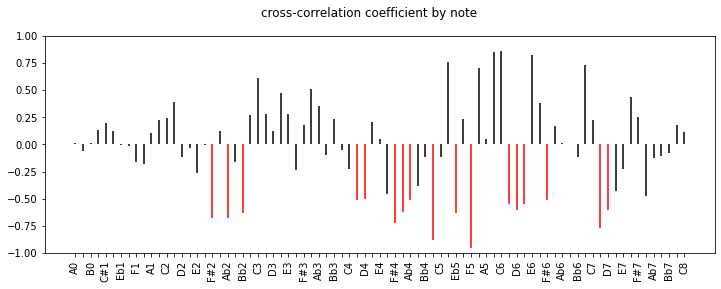

In [121]:
plot_correlation(check)
start="clip here"

### Generate complete FFT, signal, clip output for all midi clips


wrote sound clip, path=./wav/A0.vol-115.pianoteq-88.ff.48K.mic.wav
wrote sound clip, path=./wav/Bb0.vol-115.pianoteq-88.ff.48K.mic.wav
wrote sound clip, path=./wav/B0.vol-115.pianoteq-88.ff.48K.mic.wav
wrote sound clip, path=./wav/C1.vol-115.pianoteq-88.ff.48K.mic.wav
wrote sound clip, path=./wav/C#1.vol-115.pianoteq-88.ff.48K.mic.wav
wrote sound clip, path=./wav/D1.vol-115.pianoteq-88.ff.48K.mic.wav
wrote sound clip, path=./wav/Eb1.vol-115.pianoteq-88.ff.48K.mic.wav
wrote sound clip, path=./wav/E1.vol-115.pianoteq-88.ff.48K.mic.wav
wrote sound clip, path=./wav/F1.vol-115.pianoteq-88.ff.48K.mic.wav
wrote sound clip, path=./wav/G1.vol-115.pianoteq-88.ff.48K.mic.wav
wrote sound clip, path=./wav/A1.vol-115.pianoteq-88.ff.48K.mic.wav
wrote sound clip, path=./wav/B1.vol-115.pianoteq-88.ff.48K.mic.wav
wrote sound clip, path=./wav/C2.vol-115.pianoteq-88.ff.48K.mic.wav
wrote sound clip, path=./wav/C#2.vol-115.pianoteq-88.ff.48K.mic.wav
wrote sound clip, path=./wav/D2.vol-115.pianoteq-88.ff.48K

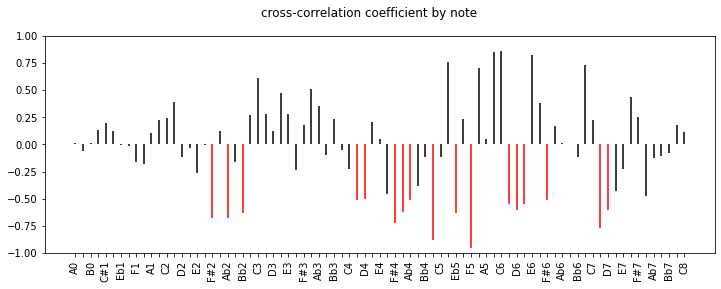

In [122]:
# calculate FFT, signal, and save clip for every note in wav
try: 
    midi_props
    # raise Exception()
except:
    mfile = "pianoteq-88.ff.mid"
    wfile = "pianoteq-88.ff.48K.binaural"
    wfile = "pianoteq-88.ff.48K.mic"
    print(f'processing midi filename={mfile}, wave filename={wfile}')
    midi_props, midi_path = generateMIDI(filename=mfile, write_file=False, midi_range="pianoteq", volumes=115)
    wav_props = get_data_from_wav(wfile)
    midi_props = clip_notes_from_data(wav_props, midi_props
        , offset=(0,100)
        , samplerate=samplerate, tempo=40)
    process_clips(midi_props)
    

# check = [ midi_props[note] for note in [0,12,45] ]
check = process_clips(midi_props)
# print(check)
for note, midi_prop in enumerate(check):
    plot_spectra2(midi_prop, samplerate=samplerate, durationMS=600
        , use_cache=False
    )
    if "save clip" and True:
        clip_name = f'{midi_prop["Note"]}.vol-{midi_prop["Volume"]}.{wav_props["basename"]}'
        play_clip(midi_prop['data'], name=clip_name, samplerate=samplerate)
plot_correlation(check)
    


In [116]:
end="clip here"

In [ ]:
## deprecate

# get plots
def plot_spectra(clip, min_peak_ratio=0.10, samplerate=44100, durationMS=600, meta={} ):
    """

    args:
        meta:{}, from generateMIDI(), expecting something like: 
            {'MIDI': 21,'Piano': 1, 'Note': 'A0', 'Frequency': 27.5, 'Tempo': 40, 'Volume': 115},
    """
    clip_spectra_by_channel = get_spectra(clip, samplerate=samplerate, durationMS=durationMS)
    result = []
    # process each channel in clip
    for ch, (xf,yf) in enumerate(clip_spectra_by_channel):
        yf_real = np.abs(yf)
        plt.plot(xf, yf_real)
        peaks_min_height = max(yf_real)*min_peak_ratio
        peaks, _ = signal.find_peaks(yf_real, height=peaks_min_height)
        x_freq = np.asarray([ xf[i] for i in peaks])
        y_amp = [ format(int(yf_real[i]), ',d') for i in peaks]

        harmonics = [frequency_to_note(f) for f in x_freq]
        # print("xf.shape=",xf.shape, xf[0:5])
        # print("yf.shape=",yf.shape, max(yf_real))
        d = {
            'fundamental': f'{harmonics[0]}, {int(x_freq[0])}Hz',
            'harmonics': harmonics,
            'frequencies': x_freq,
            'amplitude': y_amp,
            'signal': ch
        }
        # print(f'[channel-{ch}]: ')
        # print(f'  fft amp: ', y_amp)
        # print(f'  fft freq: ', x_freq)
        # print(f'  harmonics:', harmonics)
        result.append(d)
    
    fund_freq = result[0]["frequencies"][0]
    # print(fund_freq, (fund_freq/2), (2*2*2*fund_freq) )


    ### set pyplot params
    #

    # plt.xlim([ 20, 20000 ])
    plt.xlim([ max(20, fund_freq/2), min((2*2*2*fund_freq),20000) ])
    for j in range(len(clip_spectra_by_channel)):
        try:
            fundamentals.append( result[j]["fundamental"] )
        except UnboundLocalError:
            fundamentals = [ result[j]["fundamental"] ]
    if len(set(fundamentals)) == 1:
        fundamentals = fundamentals[0]

    plt.title(f'fundamental={(fundamentals)}, duration={samples2ms(clip)}ms')



    plt.show()
    return {
        'clip': clip,
        'fundamental': fundamentals,
        'channels': result
    }




def power2Db(v:float):
    """convert spectral power to db"""
    # TODO:
    db = v
    return db

(C2, C3, C5, C6, G6) = [36, 48, 72, 84, 91] # MIDI note numbers
(A0, A1, C3, C5, C6, G6) = [0, 12, 28, 52, 64, 71] # piano note numbers
(A0, A1, C3, C5, C6, G6) = [0, 10, 24, 48, 56, 63] # pianoteq note numbers

NameError: name 'np' is not defined

In [ ]:
# scratchpad
note = A0
expected, clip = midi_clips[note]
if True:
    # full_clips, _ = clip_notes_from_audio(audio, offset=0)
    # # plt.plot(clips[0])
    # plt.plot(full_clips[0])
    plt.plot(clip[0])
    plt.plot(clip[1])
    plt.show()
    props = plot_spectra(clip, samplerate=samplerate)
    

play_clip(clip, name=f'clip-{expected["Note"]}', samplerate=samplerate)

if note in [A0, 11]:
    fundamental, freq = props['fundamental'], props['channels'][0]['frequencies'][0]
    assert freq==27.5, f'ERROR: clip should be A0, 27.5Hz, got {(fundamental, freq)}'



In [ ]:
## deprecate

# read .wav file, see https://stackoverflow.com/questions/23377665/python-scipy-fft-wav-files
import os
from scipy.io import wavfile # get the api
# from scipy.signal.welch
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

# path = "./data/pianoteq.binaural.3x88.wav"
path = "./data/pianoteq-88.ff.48K.binaural.wav"
samplerate, data = wavfile.read(path) # load the data
audio = data.T # audio.shape = (channels, data)
channels, samples = audio.shape
duration = samples/samplerate
bitdepth_lu = {'int8':8., 'int16':16., 'int32':24., 'int64':64.}
bitdepth = bitdepth_lu[ type(data[0,0]).__name__ ]
print(f'channels={channels}, samples={samples}, samplerate={samplerate}, duration={duration}s, bitdepth={bitdepth}')

clips, boundaries = clip_notes_from_audio(audio, samplerate=samplerate, tempo=40)
# expected midi attrs
midi_clips = tuple(zip(midi_props, clips))
midi_clips[0:3] 



## inter-channel correlation metering
> A correlation meter calculates the cross-correlation between the L and R components of a stereo signal, usually over some integration time of about 600ms. 

see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate.html

    `signal.correlate()` seems to focus on finding the lag that maximizes the correlation of 2 signals. doesn't give an answer between [-1..1]

see: https://realpython.com/numpy-scipy-pandas-correlation-python/
- stats.pearsonr(ch1,ch2)[0], see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html
- np.corrcoef(ch1,ch2)[1,0], see: https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html
    with `np.corrcoef` we can compute the corrcoef for each combination in a multi-channel source

In [33]:
# [WRONG?] compute L/R channel correlation using signal.correlate()
# compute correlation coefficient. same as pearsonr?
clip = sliceByMs(clips[55],600)
(ch1,ch2) = clip
if "autocorrelate" and False:
    ch2=ch1
corr = signal.correlate(ch1,ch2, mode="full", method="direct")
lags = signal.correlation_lags(ch1.size, ch2.size, mode="full")
lag = lags[np.argmax(corr)]

clock = np.arange(64, len(ch1), ms2samples(50))
fig, (ax_orig, ax_noise, ax_corr) = plt.subplots(3, 1, sharex=True)
ax_orig.plot(ch1)
ax_orig.plot(clock, ch1[clock], 'ro')
ax_orig.set_title('L signal')

ax_noise.plot(ch2)
ax_noise.plot(clock, ch2[clock], 'ro')
ax_noise.set_title('R signal')
ax_corr.plot(corr)

ax_corr.plot(clock, corr[clock], 'ro')
ax_corr.axhline(0.5, ls=':')
ax_corr.set_title('Inter Channel Cross-correlation?')
ax_orig.margins(0, 0.1)
fig.tight_layout()

plt.show()


NameError: name 'clips' is not defined

In [34]:
# plot spectra and compute pearsonR cross-correlation for a range of clips
(C2, C3, C5, C6, G6) = [36, 48, 72, 84, 91] # MIDI note numbers
(A0, C3, C5, C6, G6) = [0, 28, 52, 64, 71] # piano note numbers
(A0, C3, C5, C6, G6) = [0, 24, 48, 56, 63] # pianoteq note numbers

result = {}
# for i, clip in enumerate(clips[0:88]):
# for i in range(C3, G6+1, 1):
# for i in (0,1,2,3,4,5,6,7,8, C3, C5, C6, G6):  
    # clip = clips[i]
offsetMS, durationMS = (70,600)
for i, midi_prop in enumerate(midi_props[45:45+8]):  
    clip = midi_prop['data']
    # props = plot_spectra(clip, samplerate=samplerate)
    fund, clip, channels = midi_prop['fft']['label'], midi_prop['data'],  midi_prop['fft']['channels']
    (ch1,ch2) = sliceByMs(clip,600)
    # compute correlation coefficient. same as pearsonr?
    # print("np.corrcoef=", np.corrcoef(ch1,ch2)[1,0])
    r, p = stats.pearsonr(ch1,ch2)
    print(f'clip {i}: fundamental={fund}, correlation coefficient={r:+.2f} \n')
    result[fund] = r

corrcoef = result.values()
labels = result.keys()
plt.plot(corrcoef)
plt.xticks(range(len(labels)), labels, rotation=45)
plt.ylim([-1,1])
plt.show()
print("Interchannel cross-correlation by note:\n  ", [ f'{k}: {v:+.2f} ' for k,v in zip(labels, corrcoef)])

KeyError: 'fft'

In [38]:
midi_props[45]

{'MIDI': 69,
 'Piano': 49,
 'Note': 'A4',
 'Frequency': 440.0,
 'Tempo': 40,
 'Volume': 115,
 'samplerate': 48000,
 'data': array([[ 1, -2, -1, ...,  2,  3,  4],
        [ 6,  5,  6, ..., -8, -9, -8]], dtype=int16)}